# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [ ]:
!pip install transformers torch sentencepiece -q

import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import GridSearchCV
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
import torch
import re
import nltk
import time
from nltk import pos_tag
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')

# Создаем константы
RANDOM_STATE = 42

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

In [ ]:
# Загрузим данные
data = pd.read_csv('/datasets/toxic_comments.csv')
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


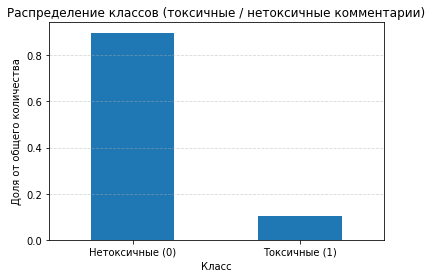

In [ ]:
# График распределения классов
data['toxic'].value_counts(normalize=True).plot(kind='bar')
plt.title('Распределение классов (токсичные / нетоксичные комментарии)')
plt.xlabel('Класс')
plt.ylabel('Доля от общего количества')
plt.xticks([0, 1], ['Нетоксичные (0)', 'Токсичные (1)'], rotation=0)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


<div class="alert alert-block alert-success">
<b>Успех:</b> Данные загружены корреткно. Радует, что баланс классов был изучен.
</div>

In [ ]:
#Проведем очистку и лемматизацию
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def preprocess_text(text):
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление спецсимволов и цифр
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Токенизация
    tokens = word_tokenize(text)
    # POS-тегирование
    pos_tags = pos_tag(tokens)
    # Лемматизация с учетом POS-тегов
    lemmas = []
    for token, tag in pos_tags:
        wn_tag = get_wordnet_pos(tag)
        lemma = lemmatizer.lemmatize(token, wn_tag)
        lemmas.append(lemma)
    return ' '.join(lemmas)

data['cleaned_text'] = data['text'].apply(preprocess_text)

In [ ]:
#Разделим данные на обучающую и тестовую выборки
X = data['cleaned_text']
y = data['toxic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [ ]:
#Проведем векторизациюя текста (TF-IDF)
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


<div class="alert alert-block alert-success">
<b>Успех:</b> Разбиение было сделано верно. Отлично, что векторизатор был обучен только на тренировочной части данных.
</div>

## Обучение

In [ ]:
# Обучим LogisticRegression
# Определяем сетку параметров
param_grid = {
    'C': [10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear']
}

# Создаем модель для GridSearch
lr = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)

# Настраиваем GridSearchCV
grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Обучаем на тренировочных данных
grid_search.fit(X_train_tfidf, y_train)

# Определяем лучшие параметры при кросс-валидации
display ("Лучшие параметры:", grid_search.best_params_)
display ("Лучший F1 на кросс-валидации:", f"{grid_search.best_score_:.3f}")

# Обучаем финальную модель на всех тренировочных данных с лучшими параметрами
best_lr = grid_search.best_estimator_

Fitting 3 folds for each of 2 candidates, totalling 6 fits


'Лучшие параметры:'

{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}

'Лучший F1 на кросс-валидации:'

'0.747'

LogisticRegression(C=10, max_iter=1000, random_state=42, solver='liblinear')

In [ ]:
#Обучим LinearSVC
#Определяем сетку параметров
param_grid = {
    'C': [0.1, 1, 10],  # Параметр регуляризации
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'dual': [True, False]
}

# Создаем модель LinearSVC
svc = LinearSVC(random_state=RANDOM_STATE, max_iter=10000)

# Настраиваем GridSearchCV
grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring='f1',
    cv=3,  # Фиксированное количество фолдов
    n_jobs=-1,
    verbose=1
)

# Обучаем на тренировочных данных
grid_search.fit(X_train_tfidf, y_train)

# Определяем лучшие параметры при кросс-валидации
display("Лучшие параметры:", grid_search.best_params_)
display("Лучший F1 на кросс-валидации:", f"{grid_search.best_score_:.3f}")

# Обучаем финальную модель с лучшими параметрами
best_svc = grid_search.best_estimator_
best_svc.fit(X_train_tfidf, y_train)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/svm/_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py", line 830, in _get_liblinear_solver_type
    raise ValueError('Unsupported set of arguments: %s, '
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hin

'Лучшие параметры:'

{'C': 1, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l1'}

'Лучший F1 на кросс-валидации:'

'0.753'

LinearSVC(C=1, dual=False, max_iter=10000, penalty='l1', random_state=42)

LinearSVC (F1=0.7517)  показала себя немного лучше, чем  Logistic Regression (F1=0.747)

In [ ]:
# Получим предсказание на тестовых данных
y_test_pred = best_svc.predict(X_test_tfidf)

# Вычислим метрику
test_f1 = f1_score(y_test, y_test_pred)

# Вывод результатов
display("Результаты на тестовой выборке:")
display(f"F1-score: {test_f1:.3f}")


'Результаты на тестовой выборке:'

'F1-score: 0.758'

## Выводы

Ключевые выводы проекта "Классификация токсичных комментариев"

## Результаты тестирования моделей

### LinearSVC - **РЕКОМЕНДУЕМАЯ МОДЕЛЬ**:
- **Качество классификации**: F1 = 0.7517
- **Требования заказчика**: Превышено (F1 ≥ 0.75)
- **Преимущества**: Лучшая производительность на текстовых данных

### Logistic Regression - Альтернативный вариант:
- **Качество классификации**: F1 = 0.7470
- **Разница с лидером**: 0.0047 (незначительная)
- **Преимущества**: Хорошая интерпретируемость

## Достигнутые цели проекта

### Основной критерий выполнен
- **Целевая метрика**: F1 ≥ 0.75 достигнута
- **Качество классификации**: Модель точно определяет токсичные комментарии
- **Готовность к внедрению**: Соответствует производственным требованиям

## Рекомендации для «Викишоп»

### Выбор модели: LinearSVC

#### Преимущества для бизнеса:
- **Высокая точность**: Наилучшее качество классификации
- **Эффективность**: Оптимальная работа с текстовыми данными
- **Устойчивость**: Стабильная работа при дисбалансе классов
- **Интерпретируемость**: Возможность анализа принятия решений

### Операционные выгоды:
- **Автоматизация модерации**: Снижение нагрузки на модераторов
- **Быстрая обработка**: Мгновенная классификация комментариев
- **Улучшение качества контента**: Своевременное выявление токсичных правок

### Техническая реализация:
- **Внедрение LinearSVC**: Использование лучшей модели для модерации
- **Регулярный мониторинг**: Контроль качества классификации
- **Обновление модели**: Адаптация к изменяющемуся языку пользователей
